In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class MatrixDataset(Dataset):
    def __init__(self, images_path, labels_path, prefix, expected_image_shape, expected_label_shape, max_samples=None):
        """
        A custom dataset that loads images and labels on demand.

        Args:
            images_path (str): Directory containing the images.
            labels_path (str): Path to the corresponding NumPy labels file.
            prefix (str): Filename prefix to filter images (e.g. "2x2_" or "3x3_").
            expected_image_shape (tuple): Expected (H, W) of the image.
            expected_label_shape (tuple): Expected shape of the label (e.g. (2,2) or (3,3)).
            max_samples (int, optional): Limit on number of samples to load.
        """
        self.images_path = images_path
        self.prefix = prefix
        self.expected_image_shape = expected_image_shape
        self.expected_label_shape = expected_label_shape

        # Load the entire labels file (usually small).
        self.labels_array = np.load(labels_path)

        # Get all filenames that match the prefix.
        all_files = os.listdir(images_path)
        self.file_list = [f for f in all_files if f.startswith(prefix)]
        if max_samples is not None:
            self.file_list = self.file_list[:max_samples]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get filename and build full path.
        filename = self.file_list[idx]
        image_path = os.path.join(self.images_path, filename)

        # Load image on demand.
        image = Image.open(image_path).convert('L')
        image = np.array(image, dtype=np.float32)
        # Normalize pixel values to [0,1].
        image = image / 255.0

        if image.shape != self.expected_image_shape:
            raise ValueError(f"Unexpected image shape {image.shape} for {image_path}. Expected {self.expected_image_shape}.")
        # Add channel dimension: (1, H, W)
        image = np.expand_dims(image, axis=0)
        image = torch.tensor(image, dtype=torch.float32)

        # Extract label index from filename (assumes format like "prefix_index.png").
        label_index = int(filename.split('_')[1].split('.')[0])
        label = self.labels_array[label_index]

        # some hard-coding to scale
        label = label / 127.0 if self.prefix == "2x2_" else label / 172.0

        # Check that the label has the expected shape. Raise an error if it doesn't.
        if label.shape != self.expected_label_shape:
            raise ValueError(f"Label shape {label.shape} for file {filename} does not match expected shape {self.expected_label_shape}.")

        # Flatten the label and convert to tensor.
        label = label.flatten()
        label = torch.tensor(label, dtype=torch.float32)

        return image, label


In [2]:
images_path = '/content/drive/MyDrive/MNIST_dataset_op/train/images'
labels_2x2_path = '/content/drive/MyDrive/MNIST_dataset_op/train/labels_2x2.npy'
labels_3x3_path = '/content/drive/MyDrive/MNIST_dataset_op/train/labels_3x3.npy'

val_path = '/content/drive/MyDrive/MNIST_dataset_op/val/images'
val_labels_2x2_path = '/content/drive/MyDrive/MNIST_dataset_op/val/labels_2x2.npy'
val_labels_3x3_path = '/content/drive/MyDrive/MNIST_dataset_op/val/labels_3x3.npy'

# For 2x2 dataset.
expected_image_shape_2x2 = (559, 1919)
expected_label_shape_2x2 = (2, 2)
dataset_2x2 = MatrixDataset(images_path, labels_2x2_path, prefix="2x2_",
                            expected_image_shape=expected_image_shape_2x2,
                            expected_label_shape=expected_label_shape_2x2)  # limit if needed
val_2x2 = MatrixDataset(val_path, val_labels_2x2_path, prefix="2x2_",
                            expected_image_shape=expected_image_shape_2x2,
                            expected_label_shape=expected_label_shape_2x2)
# For 3x3 dataset.
expected_image_shape_3x3 = (935, 2850)
expected_label_shape_3x3 = (3, 3)
dataset_3x3 = MatrixDataset(images_path, labels_3x3_path, prefix="3x3_",
                            expected_image_shape=expected_image_shape_3x3,
                            expected_label_shape=expected_label_shape_3x3)
val_3x3 = MatrixDataset(val_path, val_labels_3x3_path, prefix="3x3_",
                            expected_image_shape=expected_image_shape_3x3,
                            expected_label_shape=expected_label_shape_3x3)
# Create DataLoaders.
loader_2x2 = DataLoader(dataset_2x2, batch_size=16, shuffle=True, num_workers=1)
loader_3x3 = DataLoader(dataset_3x3, batch_size=16, shuffle=True, num_workers=1)
loader_val_2x2 = DataLoader(val_2x2, batch_size=16, shuffle=False, num_workers=1)
loader_val_3x3 = DataLoader(val_3x3, batch_size=16, shuffle=False, num_workers=1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class AggressiveCNN(nn.Module):
    def __init__(self, input_height, input_width, output_dim):
        """
        Args:
            input_height, input_width: Dimensions of the input image.
            output_dim: Number of regression outputs (4 for 2x2 data; 9 for 3x3 data).
        """
        super(AggressiveCNN, self).__init__()
        # First conv: reduce channels from 1 to 8.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Aggressive downsampling: use max pooling with kernel size 4.
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Second conv: from 8 to 16 channels.
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Further aggressive pooling with kernel size 4.
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Third conv: from 16 to 32 channels.
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # A final pooling to reduce dimensions further.
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute the flattened feature size.
        # After pool1: size becomes (input_height // 4, input_width // 4)
        # After pool2: size becomes (input_height // 16, input_width // 16)
        # After pool3: size becomes (input_height // 32, input_width // 32)
        out_h = input_height // 32
        out_w = input_width // 32
        flattened_size = 32 * out_h * out_w

        # One fully connected layer to output regression values.
        self.fc = nn.Linear(flattened_size, output_dim)

    def forward(self, x):
        # Input x shape: (batch_size, 1, H, W)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# --------------------------------------------------
# Example instantiation:
# For 2x2 data: images of size 559 x 1919, output_dim: 4.
model_2x2 = AggressiveCNN(input_height=559, input_width=1919, output_dim=4)
# For 3x3 data: images of size 935 x 2850, output_dim: 9.
model_3x3 = AggressiveCNN(input_height=935, input_width=2850, output_dim=9)

print("2x2 Model:")
print(model_2x2)
print("\n3x3 Model:")
print(model_3x3)


2x2 Model:
AggressiveCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32096, out_features=4, bias=True)
)

3x3 Model:
AggressiveCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, save_path="best_model.pt"):
    # Set device: use CUDA if available, otherwise CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    best_total_loss = float('inf')  # Initialize best combined loss as infinity

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        # Training phase.
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        total_loss = train_loss + val_loss
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Save the model if the combined loss is the best so far.
        if total_loss < best_total_loss:
            best_total_loss = total_loss
            # Move model to CPU before saving.
            model.cpu()
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model at epoch {epoch+1} with total loss: {best_total_loss:.4f}")
            # Move model back to device for further training.
            model.to(device)

        model.train()  # Set back to training mode for next epoch

    # Optionally, move the final model to CPU.
    model.cpu()

    # Plot training and validation losses.
    plt.figure(figsize=(10, 5))
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Training complete. Best combined loss:", best_total_loss)


def train_mem(model, images_tensor, labels_tensor, num_epochs=10, learning_rate=0.001, batch_size=16, save_path="model.pt"):
    # Set model to training mode.
    model.train()

    # Define the loss function and optimizer.
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create a TensorDataset and DataLoader.
    dataset = TensorDataset(images_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

    # Save the trained model.
    torch.save(model.state_dict(), save_path)
    print("Saved model to", save_path)

Epoch 1/30 - Train Loss: 0.0386 - Val Loss: 0.0402
Saved best model at epoch 1 with total loss: 0.0788
Epoch 2/30 - Train Loss: 0.0386 - Val Loss: 0.0414
Epoch 3/30 - Train Loss: 0.0363 - Val Loss: 0.0456
Epoch 4/30 - Train Loss: 0.0369 - Val Loss: 0.0399
Saved best model at epoch 4 with total loss: 0.0767
Epoch 5/30 - Train Loss: 0.0368 - Val Loss: 0.0390
Saved best model at epoch 5 with total loss: 0.0758
Epoch 6/30 - Train Loss: 0.0361 - Val Loss: 0.0391
Saved best model at epoch 6 with total loss: 0.0752
Epoch 7/30 - Train Loss: 0.0355 - Val Loss: 0.0399
Epoch 8/30 - Train Loss: 0.0345 - Val Loss: 0.0446
Epoch 9/30 - Train Loss: 0.0354 - Val Loss: 0.0383
Saved best model at epoch 9 with total loss: 0.0737
Epoch 10/30 - Train Loss: 0.0345 - Val Loss: 0.0406
Epoch 11/30 - Train Loss: 0.0343 - Val Loss: 0.0382
Saved best model at epoch 11 with total loss: 0.0725
Epoch 12/30 - Train Loss: 0.0339 - Val Loss: 0.0377
Saved best model at epoch 12 with total loss: 0.0717
Epoch 13/30 - Train

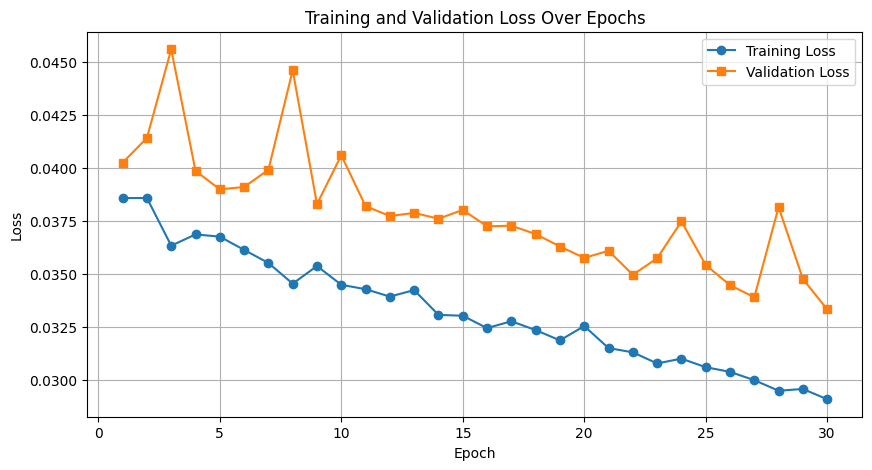

Training complete. Best combined loss: 0.06242985506180235


In [5]:
# For 2x2 data:
train_model(model_2x2, loader_2x2, loader_val_2x2, num_epochs=30, learning_rate=0.005, save_path="best_model_2x2.pt")


Epoch 1/30 - Train Loss: 0.0425 - Val Loss: 0.0363
Saved best model at epoch 1 with total loss: 0.0787
Epoch 2/30 - Train Loss: 0.0387 - Val Loss: 0.0362
Saved best model at epoch 2 with total loss: 0.0749
Epoch 3/30 - Train Loss: 0.0385 - Val Loss: 0.0363
Saved best model at epoch 3 with total loss: 0.0748
Epoch 4/30 - Train Loss: 0.0386 - Val Loss: 0.0361
Saved best model at epoch 4 with total loss: 0.0747
Epoch 5/30 - Train Loss: 0.0387 - Val Loss: 0.0363
Epoch 6/30 - Train Loss: 0.0384 - Val Loss: 0.0360
Saved best model at epoch 6 with total loss: 0.0744
Epoch 7/30 - Train Loss: 0.0384 - Val Loss: 0.0361
Epoch 8/30 - Train Loss: 0.0384 - Val Loss: 0.0360
Saved best model at epoch 8 with total loss: 0.0744
Epoch 9/30 - Train Loss: 0.0382 - Val Loss: 0.0362
Saved best model at epoch 9 with total loss: 0.0744
Epoch 10/30 - Train Loss: 0.0383 - Val Loss: 0.0360
Saved best model at epoch 10 with total loss: 0.0743
Epoch 11/30 - Train Loss: 0.0383 - Val Loss: 0.0360
Epoch 12/30 - Train 

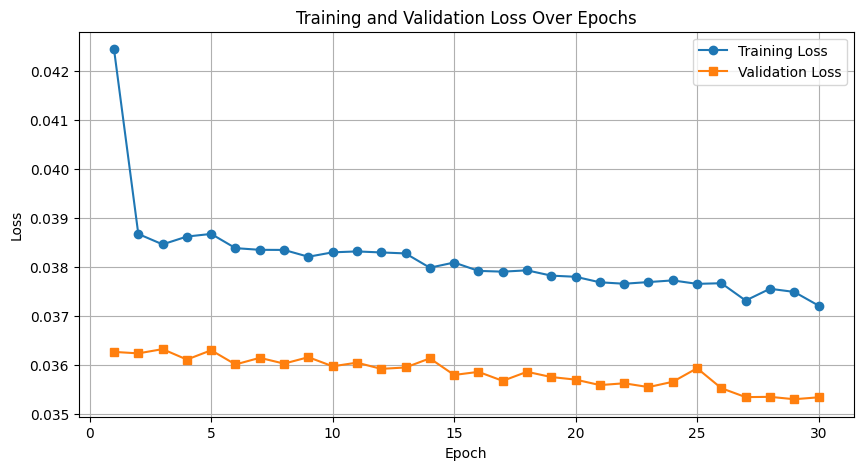

Training complete. Best combined loss: 0.07255265996196217


In [ ]:

# For 3x3 data:
train_model(model_3x3, loader_3x3, loader_val_3x3, num_epochs=30, learning_rate=0.005, save_path="best_model_3x3.pt")

In [7]:
# Create a test dataset for 2x2 data.
test_images_path_2x2 = '/content/drive/MyDrive/MNIST_dataset_op/test/images'
test_labels_2x2_path = '/content/drive/MyDrive/MNIST_dataset_op/test/labels_2x2.npy'
expected_image_shape_2x2 = (559, 1919)
expected_label_shape_2x2 = (2, 2)
test_dataset_2x2 = MatrixDataset(test_images_path_2x2, test_labels_2x2_path, prefix="2x2_",
                                 expected_image_shape=expected_image_shape_2x2,
                                 expected_label_shape=expected_label_shape_2x2)
loader_test_2x2 = DataLoader(test_dataset_2x2, batch_size=16, shuffle=False, num_workers=1)

# Create a test dataset for 3x3 data.
test_images_path_3x3 = '/content/drive/MyDrive/MNIST_dataset_op/test/images'
test_labels_3x3_path = '/content/drive/MyDrive/MNIST_dataset_op/test/labels_3x3.npy'
expected_image_shape_3x3 = (935, 2850)
expected_label_shape_3x3 = (3, 3)
test_dataset_3x3 = MatrixDataset(test_images_path_3x3, test_labels_3x3_path, prefix="3x3_",
                                 expected_image_shape=expected_image_shape_3x3,
                                 expected_label_shape=expected_label_shape_3x3)
loader_test_3x3 = DataLoader(test_dataset_3x3, batch_size=16, shuffle=False, num_workers=1)

def test_model(model, test_loader, device, scale_factor):
    """
    Tests the model on the test dataset and returns the accuracy.

    The model's outputs and the targets are assumed to be normalized.
    They are multiplied by the scale_factor to invert the normalization,
    then rounded to the nearest integer and compared as flattened vectors.

    Args:
      model: the trained model.
      test_loader: DataLoader for the test dataset.
      device: the torch device (e.g., cuda or cpu).
      scale_factor: the factor used to normalize the labels during training.
                    (e.g., 127.0 for 2x2 data, 172.0 for 3x3 data)

    Returns:
      accuracy: fraction of test samples that are predicted exactly correctly.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Invert normalization.
            outputs = outputs * scale_factor
            targets = targets * scale_factor
            # Round to nearest integer.
            outputs = torch.round(outputs)
            targets = torch.round(targets)
            # Move back to CPU.
            outputs = outputs.cpu()
            targets = targets.cpu()
            # Compare flattened vectors directly.
            for i in range(outputs.shape[0]):
                if torch.equal(outputs[i], targets[i]):
                    correct += 1
                total += 1
    accuracy = correct / total if total > 0 else 0
    return accuracy


# --- Load best models and test them.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your 2x2 model and move it to device.
model_2x2.load_state_dict(torch.load("best_model_2x2.pt", map_location=device))
model_2x2.to(device)
accuracy_2x2 = test_model(model_2x2, loader_test_2x2, device=device, scale_factor=127.0)
print("2x2 Test Accuracy:", accuracy_2x2)


# Load your 3x3 model and move it to device.
model_3x3.load_state_dict(torch.load("best_model_3x3.pt", map_location=device))
model_3x3.to(device)
accuracy_3x3 = test_model(model_3x3, loader_test_3x3, device=device, scale_factor=172.0)
print("3x3 Test Accuracy:", accuracy_3x3)

2x2 Test Accuracy: 0.0
3x3 Test Accuracy: 0.0


In [15]:
brand_new_test_2x2 = "/content/drive/MyDrive/e_handwritten/images"
brand_new_test_2x2_label = "/content/drive/MyDrive/e_handwritten/labels_2x2.npy"

brand_new_test_3x3 = "/content/drive/MyDrive/e_handwritten/images"
brand_new_test_3x3_label = "/content/drive/MyDrive/e_handwritten/labels_3x3.npy"

In [16]:
labels_2x2 = np.load(brand_new_test_2x2_label)
labels_3x3 = np.load(brand_new_test_3x3_label)
# Find the maximum element in each label array
max_2x2 = labels_2x2.max()
max_3x3 = labels_3x3.max()
min_2x2 = labels_2x2.min()
min_3x3 = labels_3x3.min()
print("Maximum element in brand_new_test_2x2_label:", max_2x2)
print("Maximum element in brand_new_test_3x3_label:", max_3x3)
print("Minimum element in brand_new_test_2x2_label:", min_2x2)
print("Minimum element in brand_new_test_3x3_label:", min_3x3)

Maximum element in brand_new_test_2x2_label: 116
Maximum element in brand_new_test_3x3_label: 106
Minimum element in brand_new_test_2x2_label: -7
Minimum element in brand_new_test_3x3_label: -8


In [19]:
class HandwrittenDataset(Dataset):
    def __init__(self, images_path, labels_path, prefix, expected_image_shape, expected_label_shape, max_samples=None):
        """
        A custom dataset that loads images and labels on demand.

        Args:
            images_path (str): Directory containing the images.
            labels_path (str): Path to the corresponding NumPy labels file.
            prefix (str): Filename prefix to filter images (e.g. "2x2_" or "3x3_").
            expected_image_shape (tuple): Expected (H, W) of the image.
            expected_label_shape (tuple): Expected shape of the label (e.g. (2,2) or (3,3)).
            max_samples (int, optional): Limit on number of samples to load.
        """
        self.images_path = images_path
        self.prefix = prefix
        self.expected_image_shape = expected_image_shape
        self.expected_label_shape = expected_label_shape

        # Load the entire labels file (usually small).
        self.labels_array = np.load(labels_path)

        # Get all filenames that match the prefix.
        all_files = os.listdir(images_path)
        self.file_list = [f for f in all_files if f.startswith(prefix)]
        if max_samples is not None:
            self.file_list = self.file_list[:max_samples]

    def __len__(self):
        return len(self.file_list)


    # FOR NEW DATA:
    # 1. Do reshape
    # 2. hard-coded scaling must now be adjusted to new dataset.
    # TODO: ideally the scaling factor is automatically determined with the labels,
    # but for now only manual checking the max/min values and adjusting based on those values
    def __getitem__(self, idx):
        # Get filename and build full path.
        filename = self.file_list[idx]
        image_path = os.path.join(self.images_path, filename)

        # Load image on demand.
        image = Image.open(image_path).convert('L')
        image = np.array(image, dtype=np.float32)
        # Normalize pixel values to [0,1].
        image = image / 255.0

        # UPDATE force the input to be expected dimensions
        if image.shape != self.expected_image_shape:
            image = Image.fromarray(image).resize(self.expected_image_shape)  # Create Pillow Image
            image = np.array(image, dtype=np.float32)  # Convert back to NumPy array
        image = np.expand_dims(image, axis=0)
        image = torch.tensor(image, dtype=torch.float32)

        # Extract label index from filename (assumes format like "prefix_index.png").
        label_index = int(filename.split('_')[1].split('.')[0])
        label = self.labels_array[label_index]

        # UPDATE the values for new handwritten dataset
        label = label / 116.0 if self.prefix == "2x2_" else label / 106.0

        # Check that the label has the expected shape. Raise an error if it doesn't.
        if label.shape != self.expected_label_shape:
            raise ValueError(f"Label shape {label.shape} for file {filename} does not match expected shape {self.expected_label_shape}.")

        # Flatten the label and convert to tensor.
        label = label.flatten()
        label = torch.tensor(label, dtype=torch.float32)

        return image, label


In [20]:
# Create HandwrittenDataset instances for the new test data.
brand_new_test_2x2_dataset = HandwrittenDataset(brand_new_test_2x2, brand_new_test_2x2_label, prefix="2x2_",
                                                expected_image_shape=expected_image_shape_2x2,
                                                expected_label_shape=expected_label_shape_2x2)
brand_new_test_3x3_dataset = HandwrittenDataset(brand_new_test_3x3, brand_new_test_3x3_label, prefix="3x3_",
                                                expected_image_shape=expected_image_shape_3x3,
                                                expected_label_shape=expected_label_shape_3x3)

# Create DataLoaders for the new test datasets.
brand_new_test_2x2_loader = DataLoader(brand_new_test_2x2_dataset, batch_size=16, shuffle=False, num_workers=1)
brand_new_test_3x3_loader = DataLoader(brand_new_test_3x3_dataset, batch_size=16, shuffle=False, num_workers=1)


# Evaluate the models on the new test data.
accuracy_brand_new_2x2 = test_model(model_2x2, brand_new_test_2x2_loader, device=device, scale_factor=116.0) # Use the appropriate scale factor
print("Brand New 2x2 Test Accuracy:", accuracy_brand_new_2x2)

accuracy_brand_new_3x3 = test_model(model_3x3, brand_new_test_3x3_loader, device=device, scale_factor=106.0) # Use the appropriate scale factor
print("Brand New 3x3 Test Accuracy:", accuracy_brand_new_3x3)


Brand New 2x2 Test Accuracy: 0.0
Brand New 3x3 Test Accuracy: 0.0
